In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
from Ingestion.kivadataloader import KivaDataLoader
import pandas as pd

m = KivaDataLoader()
cleaneduploans = m.get_clean_dataframe()

In [5]:
cleaneduploans.shape

(1170548, 66)

# Target and Features

In [15]:
#Target
y = cleaneduploans['posted_to_raised_days']

In [77]:
yb = cleaneduploans['posted_to_raised_bins']

In [18]:
y.shape

(1170548,)

In [78]:
yb.shape

(1170548,)

In [182]:
#Features
X = cleaneduploans.drop(['posted_to_raised_days', 'posted_to_raised_bins', 'disburse_to_posted_days','disbursed_to_raised_days','partner_id'], axis=1)

In [157]:
X.shape

(1170548, 61)

In [158]:
X.dtypes

loan_id                                                      int64
loan_name                                                   object
language_english                                             int64
description_length                                         float64
funded_amount                                              float64
loan_amount                                                float64
status_loans                                                object
loan_image_provided                                          int64
loan_video_provided                                          int64
activity_name                                               object
loan_use_length                                            float64
country_code                                                object
country_name                                                object
currency_policy                                             object
currency_exchange_coverage_rate                            flo

In [183]:
#To keep only numeric variables
X = X.select_dtypes(exclude=['object','datetime64[ns, UTC]'])

In [160]:
X.shape

(1170548, 44)

In [161]:
X.describe()

,loan_id,language_english,description_length,funded_amount,loan_amount,loan_image_provided,loan_video_provided,loan_use_length,currency_exchange_coverage_rate,currency_usd,...,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,distribution_model_field_partner,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly
count,1.170548e+06,1.170548e+06,1.170522e+06,1.170548e+06,1.170548e+06,1170548.0,1.170548e+06,1.170532e+06,906683.000000,1.170548e+06,...,1.170548e+06,1.170548e+06,1.170548e+06,1.170548e+06,1.170548e+06,1.170548e+06,1170548.0,1.170548e+06,1.170548e+06,1.170548e+06
mean,7.045821e+05,6.886971e-01,7.550053e+02,7.549700e+02,7.549698e+02,1.0,4.032299e-04,5.368858e+01,0.118012,1.555049e-01,...,1.289738e-02,3.849735e-02,2.001703e-01,6.985104e-02,2.571787e-02,1.587291e-03,1.0,6.880196e-02,4.130074e-01,5.181906e-01
std,4.220334e+05,4.630266e-01,4.045051e+02,9.800246e+02,9.800240e+02,0.0,2.007655e-02,2.817352e+01,0.038429,3.623855e-01,...,1.128319e-01,1.923937e-01,4.001279e-01,2.548959e-01,1.582924e-01,3.980920e-02,0.0,2.531172e-01,4.923743e-01,4.996692e-01
min,3.080000e+02,0.000000e+00,1.000000e+00,2.500000e+01,2.500000e+01,1.0,0.000000e+00,1.000000e+00,0.100000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.300058e+05,0.000000e+00,4.910000e+02,2.750000e+02,2.750000e+02,1.0,0.000000e+00,3.400000e+01,0.100000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.848595e+05,1.000000e+00,6.450000e+02,4.750000e+02,4.750000e+02,1.0,0.000000e+00,4.800000e+01,0.100000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.066568e+06,1.000000e+00,8.930000e+02,9.000000e+02,9.000000e+02,1.0,0.000000e+00,6.800000e+01,0.100000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00,1.000000e+00
max,1.444068e+06,1.000000e+00,1.161000e+04,1.000000e+05,1.000000e+05,1.0,1.000000e+00,2.149000e+03,0.200000,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00


In [162]:
print(X.isnull().sum())

loan_id                                   0
language_english                          0
description_length                       26
funded_amount                             0
loan_amount                               0
loan_image_provided                       0
loan_video_provided                       0
loan_use_length                          16
currency_exchange_coverage_rate      263865
currency_usd                              0
num_journal_entries                       0
num_bulk_entries                          0
tags_exist                                0
atleast1_borrower_pictured                0
partner_total_amount_raised               0
partner_loans_posted                      0
partner_charges_fees_and_interest         0
partner_loans_at_risk_rate                0
partner_url_length                        0
partner_portfolio_yield               87165
partner_profitability                102336
num_borrowers_female                      0
num_borrowers_male              

In [184]:
#Replace nan values with 0 for description lenght 
#and average of columns for loan use lenght
X['description_length'].fillna(0,inplace=True)
X['loan_use_length'].fillna(X['loan_use_length'].mean(),inplace=True)

In [185]:
#Remove columns with nan values (the remaining three features have large amount of missing values and are related to field partner - which in previous analysis show to be less relevant) 
X.dropna(axis=1, inplace=True)

In [165]:
print(X.isnull().sum())

loan_id                              0
language_english                     0
description_length                   0
funded_amount                        0
loan_amount                          0
loan_image_provided                  0
loan_video_provided                  0
loan_use_length                      0
currency_usd                         0
num_journal_entries                  0
num_bulk_entries                     0
tags_exist                           0
atleast1_borrower_pictured           0
partner_total_amount_raised          0
partner_loans_posted                 0
partner_charges_fees_and_interest    0
partner_loans_at_risk_rate           0
partner_url_length                   0
num_borrowers_female                 0
num_borrowers_male                   0
num_borrowers                        0
num_borrowers_female_pct             0
sector_name_Agriculture              0
sector_name_Arts                     0
sector_name_Clothing                 0
sector_name_Construction 

In [186]:
X.shape

(1170548, 41)

In [166]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [167]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'funded_amount', 'loan_use_length', 'partner_loans_at_risk_rate', 'num_borrowers_female']


In [168]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'funded_amount', 'loan_use_length', 'partner_loans_at_risk_rate', 'num_borrowers_female']


In [169]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(X, yb)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'funded_amount']


In [170]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['language_english', 'tags_exist', 'partner_charges_fees_and_interest', 'num_borrowers_female_pct', 'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing', 'sector_name_Education', 'sector_name_Entertainment', 'sector_name_Food', 'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing', 'sector_name_Personal Use', 'sector_name_Retail', 'sector_name_Transportation', 'repayment_interval_irregular']


In [171]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(X, yb)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['language_english', 'tags_exist', 'partner_charges_fees_and_interest', 'num_borrowers_female_pct', 'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing', 'sector_name_Education', 'sector_name_Entertainment', 'sector_name_Food', 'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing', 'sector_name_Personal Use', 'sector_name_Retail', 'sector_name_Transportation', 'repayment_interval_irregular']


In [172]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['tags_exist', 'partner_loans_at_risk_rate', 'num_borrowers_female']


In [173]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(X, yb)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['description_length', 'funded_amount', 'loan_use_length', 'partner_loans_at_risk_rate']


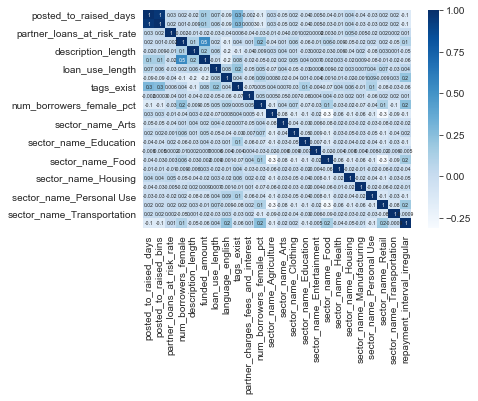

In [175]:
corr = cleaneduploans[['posted_to_raised_days','posted_to_raised_bins', 'num_borrowers_female','description_length', 'funded_amount', 'loan_use_length','language_english', 'tags_exist', 'partner_charges_fees_and_interest', 'num_borrowers_female_pct', 'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing', 'sector_name_Education', 'sector_name_Entertainment', 'sector_name_Food', 'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing', 'sector_name_Personal Use', 'sector_name_Retail', 'sector_name_Transportation', 'repayment_interval_irregular', 'partner_loans_at_risk_rate']].corr(method='pearson')
sns.heatmap(corr, annot = True, fmt =".1g", annot_kws={"size": 5}, cmap = "Blues")

In [125]:
pca = PCA(n_components=2)
pca_f = pca.fit(X).transform(X)

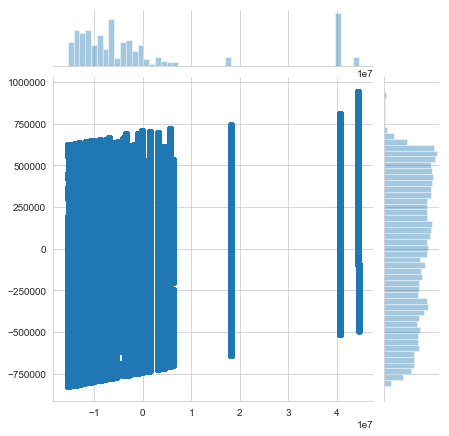

In [114]:
sns.jointplot(pca_f[:,0], pca_f[:,1])

In [123]:
lda = LDA(n_components=2)
lda_f = lda.fit(X, y).transform(X)

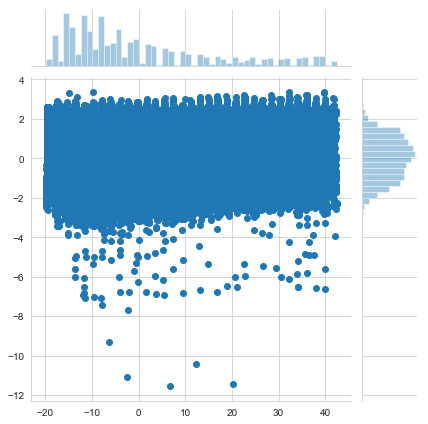

In [124]:
sns.jointplot(lda_f[:,0], lda_f[:,1])

In [121]:
lda = LDA(n_components=2)
lda_f = lda.fit(X, yb).transform(X)

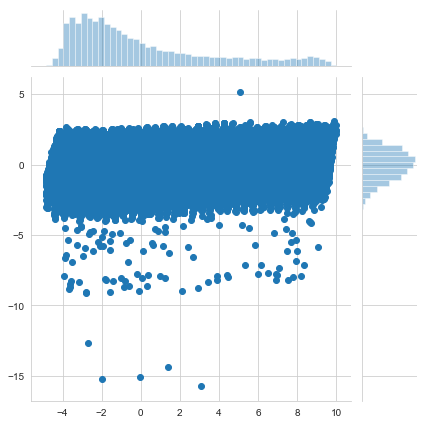

In [122]:
sns.jointplot(lda_f[:,0], lda_f[:,1])